In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-pharmaceutical-products/indian_pharmaceutical_products_clean.csv


# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [3]:
df = pd.read_csv('/kaggle/input/indian-pharmaceutical-products/indian_pharmaceutical_products_clean.csv')

# Eksploratory Data Analysis

In [4]:
df.head()

,product_id,brand_name,manufacturer,price_inr,is_discontinued,dosage_form,pack_size,pack_unit,num_active_ingredients,primary_ingredient,primary_strength,active_ingredients,therapeutic_class,packaging_raw,manufacturer_raw
0,1,Augmentin 625 Duo Tablet,Glaxo SmithKline Pharmaceuticals Ltd,223.42,False,tablet,10.0,strip,2,Amoxycillin,500mg,"[{'name': 'Amoxycillin', 'strength': '500mg', ...",antibiotic,strip of 10 tablets,Glaxo SmithKline Pharmaceuticals Ltd
1,2,Azithral 500 Tablet,Alembic Pharmaceuticals Ltd,132.36,False,tablet,5.0,strip,1,Azithromycin,500mg,"[{'name': 'Azithromycin', 'strength': '500mg',...",antibiotic,strip of 5 tablets,Alembic Pharmaceuticals Ltd
2,3,Ascoril LS Syrup,Glenmark Pharmaceuticals Ltd,118.00,False,syrup,100.0,bottle,2,Ambroxol,30mg/5ml,"[{'name': 'Ambroxol', 'strength': '30mg/5ml', ...",bronchodilator,bottle of 100 ml Syrup,Glenmark Pharmaceuticals Ltd
3,4,Allegra 120mg Tablet,Sanofi India Ltd,218.81,False,tablet,10.0,strip,1,Fexofenadine,120mg,"[{'name': 'Fexofenadine', 'strength': '120mg',...",antihistamine,strip of 10 tablets,Sanofi India Ltd
4,5,Avil 25 Tablet,Sanofi India Ltd,10.96,False,tablet,15.0,strip,1,Pheniramine,25mg,"[{'name': 'Pheniramine', 'strength': '25mg', '...",other,strip of 15 tablets,Sanofi India Ltd


In [5]:
print(df.shape)

(253973, 15)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253973 entries, 0 to 253972
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   product_id              253973 non-null  int64  
 1   brand_name              253973 non-null  object 
 2   manufacturer            253973 non-null  object 
 3   price_inr               253973 non-null  float64
 4   is_discontinued         253973 non-null  bool   
 5   dosage_form             253973 non-null  object 
 6   pack_size               231643 non-null  float64
 7   pack_unit               231643 non-null  object 
 8   num_active_ingredients  253973 non-null  int64  
 9   primary_ingredient      253973 non-null  object 
 10  primary_strength        228775 non-null  object 
 11  active_ingredients      253973 non-null  object 
 12  therapeutic_class       253973 non-null  object 
 13  packaging_raw           253973 non-null  object 
 14  manufacturer_raw    

In [7]:
df.isna().sum()

product_id                    0
brand_name                    0
manufacturer                  0
price_inr                     0
is_discontinued               0
dosage_form                   0
pack_size                 22330
pack_unit                 22330
num_active_ingredients        0
primary_ingredient            0
primary_strength          25198
active_ingredients            0
therapeutic_class             0
packaging_raw                 0
manufacturer_raw              0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,product_id,price_inr,pack_size,num_active_ingredients
count,253973.000000,253973.000000,231643.000000,253973.000000
mean,126987.000000,270.530844,18.988871,1.441893
std,73315.834296,3029.584134,36.717320,0.496795
min,1.000000,0.000000,1.000000,1.000000
25%,63494.000000,48.000000,10.000000,1.000000
50%,126987.000000,79.000000,10.000000,1.000000
75%,190480.000000,140.000000,10.000000,2.000000
max,253973.000000,436000.000000,5000.000000,5.000000


## Univariate Analysis

Text(0.5, 0, 'Harga (INR)')

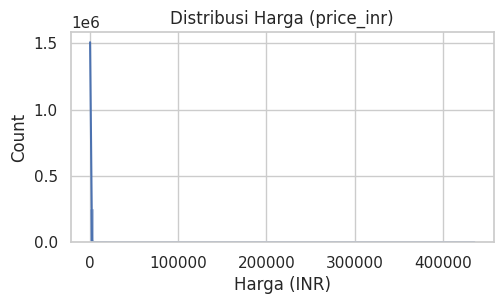

In [10]:
# Plot distribusi harga
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['price_inr'], bins=100, kde=True)
plt.title("Distribusi Harga (price_inr)")
plt.xlabel("Harga (INR)")

Text(0.5, 0, 'Ukuran Kemasan')

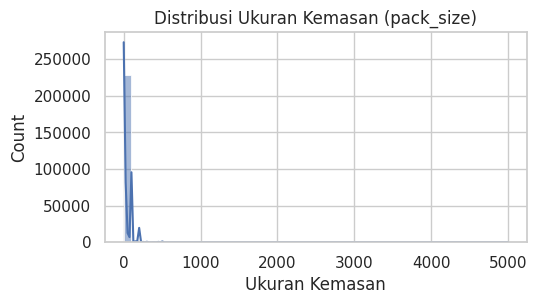

In [11]:
# Plot distribusi ukuran kemasan (pack_size)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 2)
sns.histplot(df['pack_size'].dropna(), bins=50, kde=True)
plt.title("Distribusi Ukuran Kemasan (pack_size)")
plt.xlabel("Ukuran Kemasan")

Text(0.5, 0, 'Jumlah Zat Aktif')

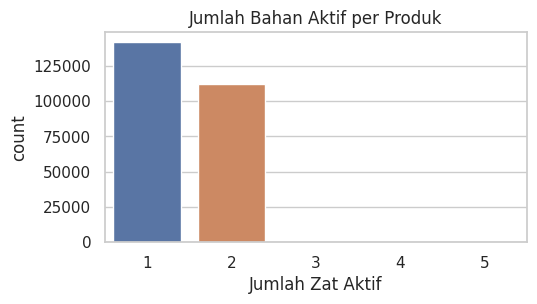

In [12]:
# Plot jumlah zat aktif
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 3)
sns.countplot(x='num_active_ingredients', data=df)
plt.title("Jumlah Bahan Aktif per Produk")
plt.xlabel("Jumlah Zat Aktif")

Text(0.5, 0, 'Discontinued?')

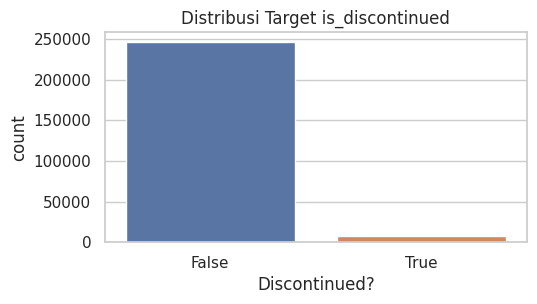

In [13]:
# Plot target (is_discontinued)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 4)
sns.countplot(x='is_discontinued', data=df)
plt.title("Distribusi Target is_discontinued")
plt.xlabel("Discontinued?")

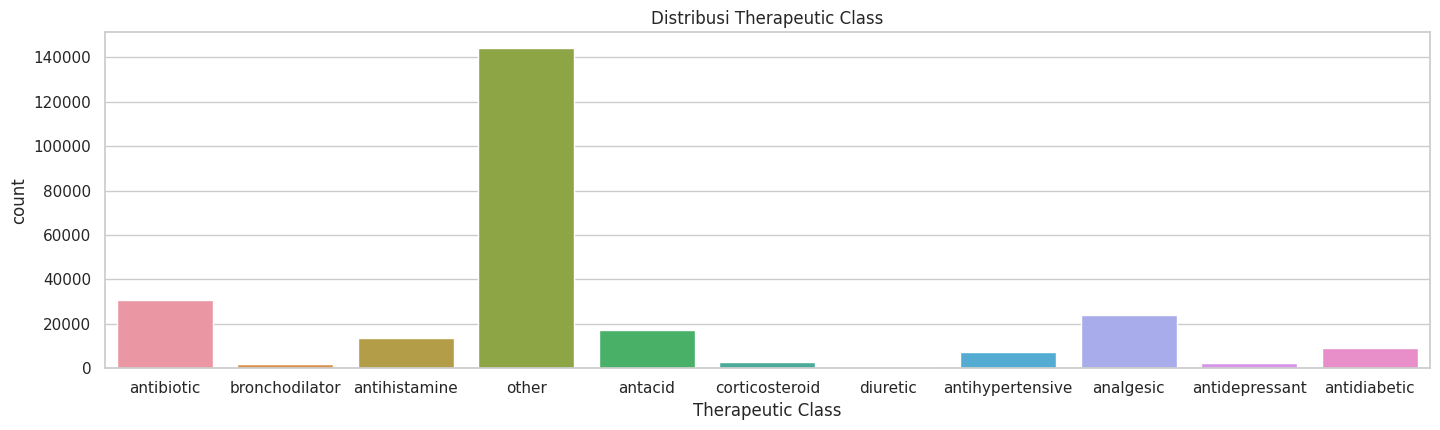

In [14]:
# Plot target (therapeutic_class)
sns.set(style="whitegrid")
plt.figure(figsize=(28, 8))
plt.subplot(2, 2, 4)
sns.countplot(x='therapeutic_class', data=df)
plt.title("Distribusi Therapeutic Class")
plt.xlabel("Therapeutic Class")
plt.tight_layout()
plt.show()

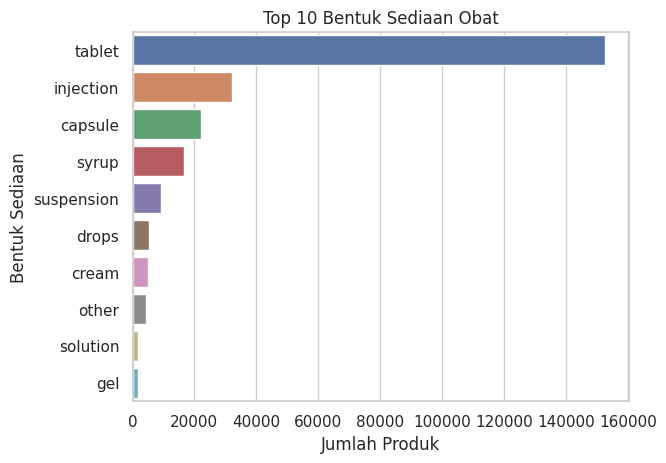

In [15]:
sns.countplot(data=df, y='dosage_form', order=df['dosage_form'].value_counts().head(10).index)
plt.title('Top 10 Bentuk Sediaan Obat')
plt.xlabel('Jumlah Produk')
plt.ylabel('Bentuk Sediaan')
plt.show()

Text(0.5, 0, 'Pack Unit')

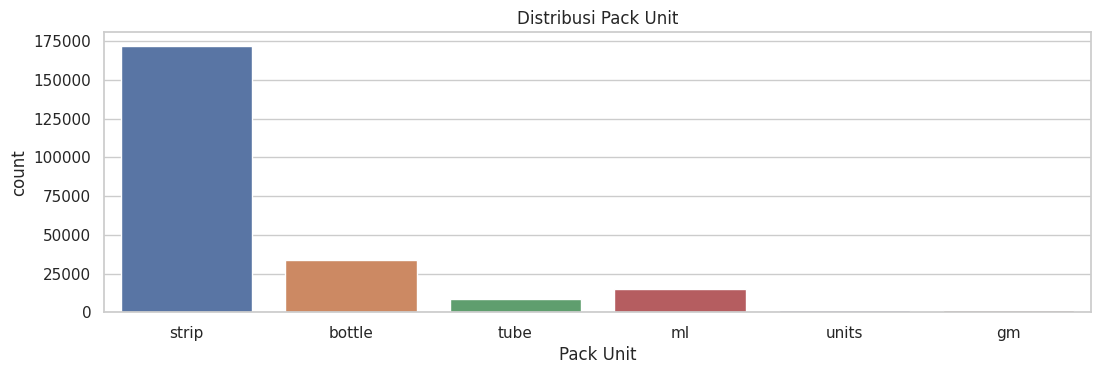

In [16]:
# Plot target (pack_unit)
sns.set(style="whitegrid")
plt.figure(figsize=(28, 8))
plt.subplot(2, 2, 4)
sns.countplot(x='pack_unit', data=df)
plt.title("Distribusi Pack Unit")
plt.xlabel("Pack Unit")

Text(0.5, 1.0, 'Top 15 Manufacturer')

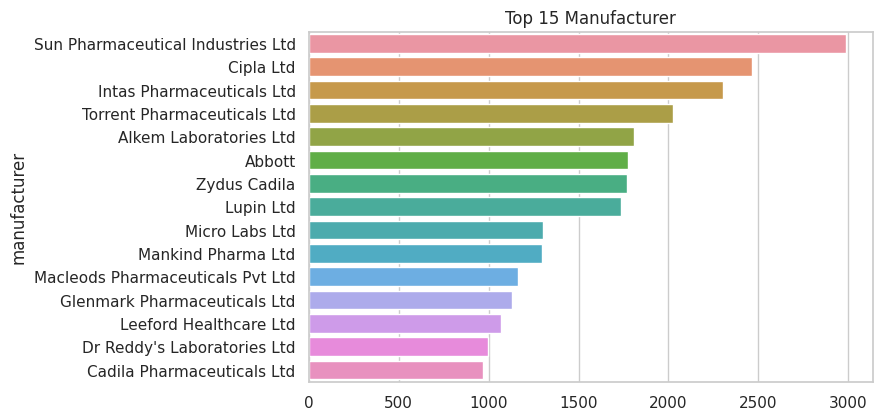

In [17]:
# Plot Distribusi manufacturer (Top 15)
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 4)
top_manufacturers = df['manufacturer'].value_counts().nlargest(15)
sns.barplot(y=top_manufacturers.index, x=top_manufacturers.values)
plt.title("Top 15 Manufacturer")

## Multivariate Analysis

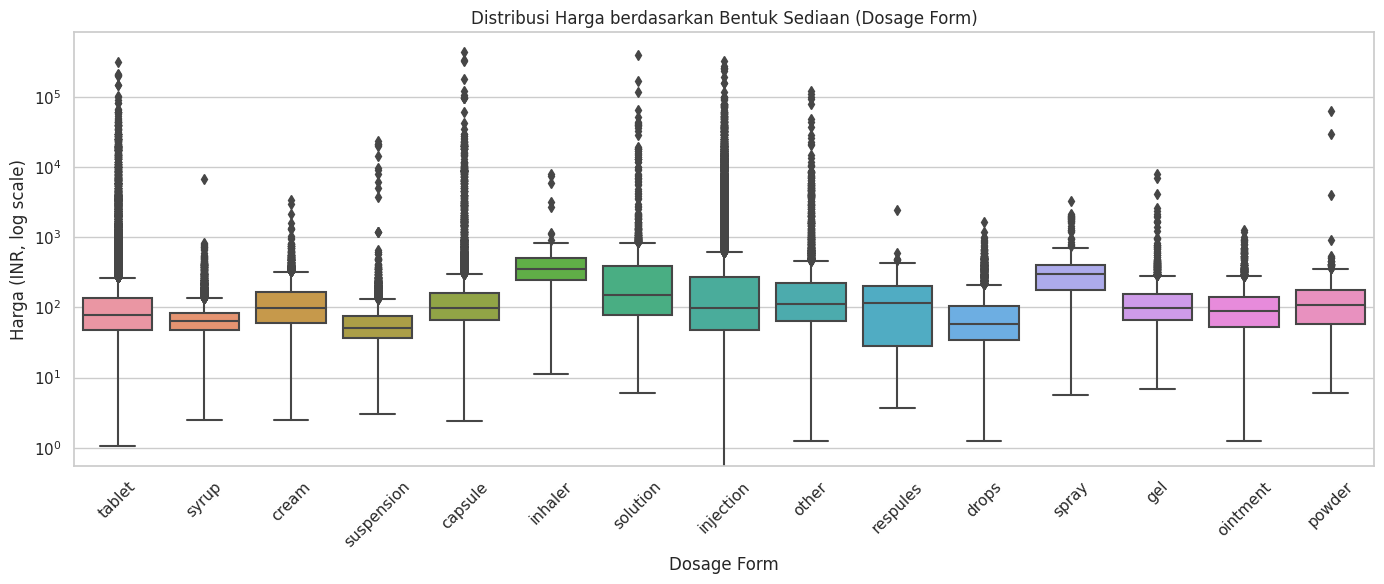

In [18]:
# Distribusi Harga Berdasarkan dosage_form
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='dosage_form', y='price_inr')
plt.xticks(rotation=45)
plt.yscale('log')  # Karena harga sangat lebar sebarannya
plt.title('Distribusi Harga berdasarkan Bentuk Sediaan (Dosage Form)')
plt.xlabel('Dosage Form')
plt.ylabel('Harga (INR, log scale)')
plt.tight_layout()
plt.show()

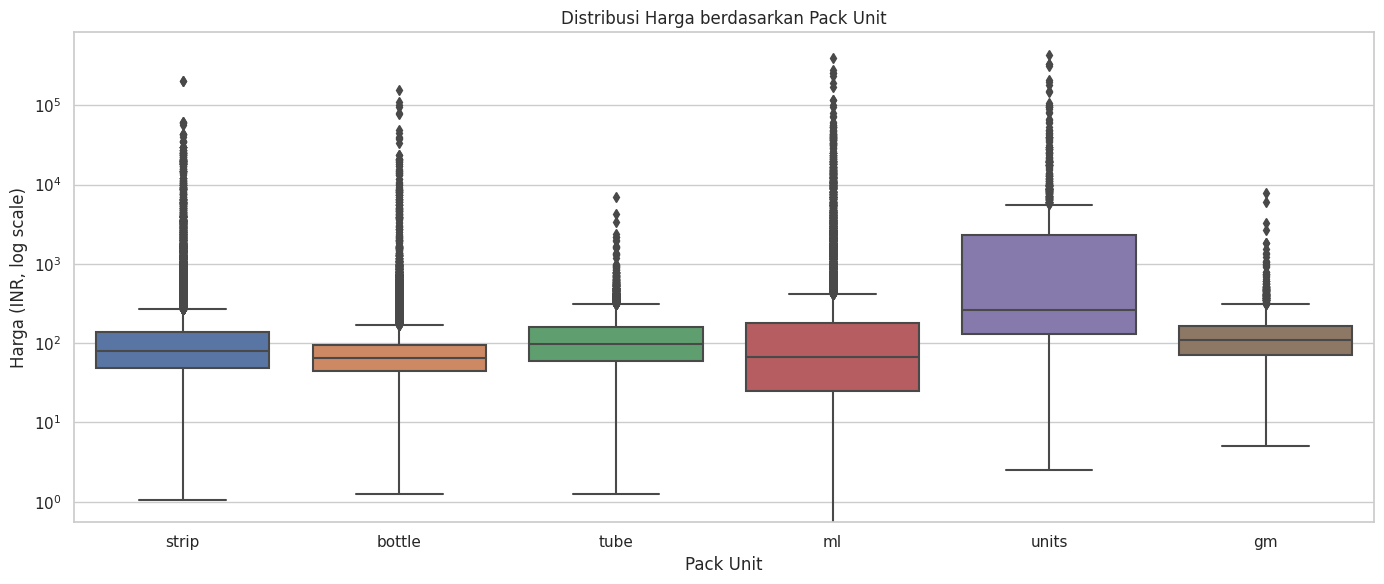

In [19]:
# Harga vs pack_unit (Jenis Unit Kemasan)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='pack_unit', y='price_inr')
plt.yscale('log')
plt.title('Distribusi Harga berdasarkan Pack Unit')
plt.xlabel('Pack Unit')
plt.ylabel('Harga (INR, log scale)')
plt.tight_layout()
plt.show()

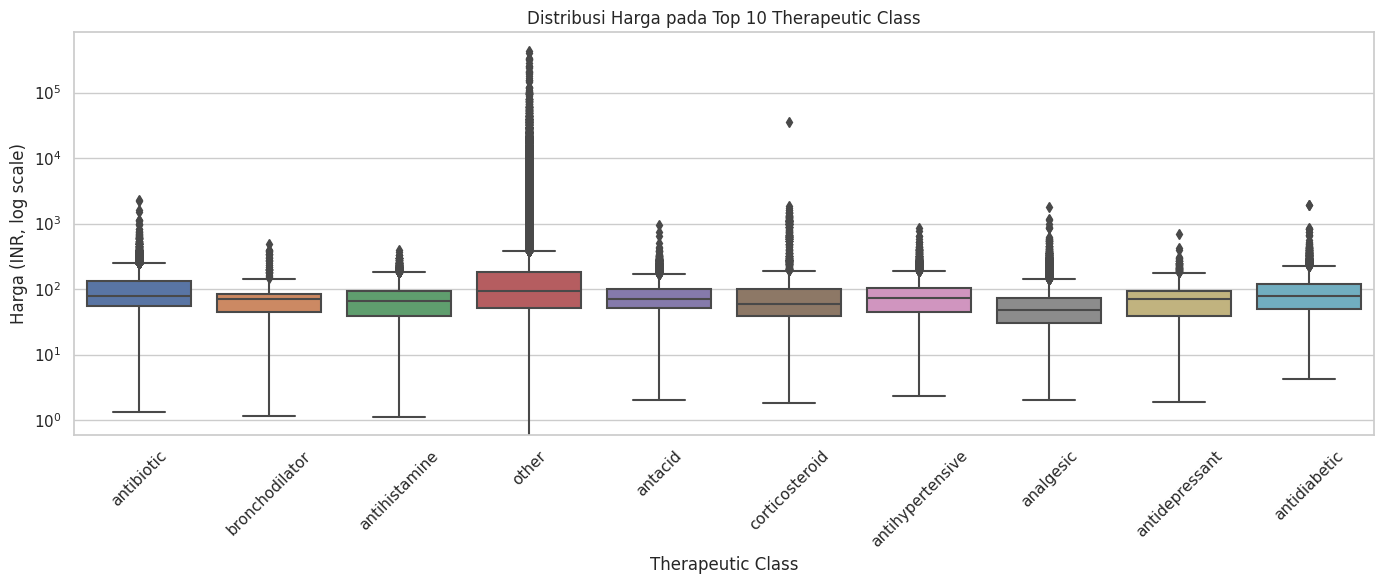

In [20]:
# Harga Berdasarkan therapeutic_class
top_classes = df['therapeutic_class'].value_counts().head(10).index
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[df['therapeutic_class'].isin(top_classes)],
            x='therapeutic_class', y='price_inr')
plt.xticks(rotation=45)
plt.yscale('log')
plt.title('Distribusi Harga pada Top 10 Therapeutic Class')
plt.xlabel('Therapeutic Class')
plt.ylabel('Harga (INR, log scale)')
plt.tight_layout()
plt.show()

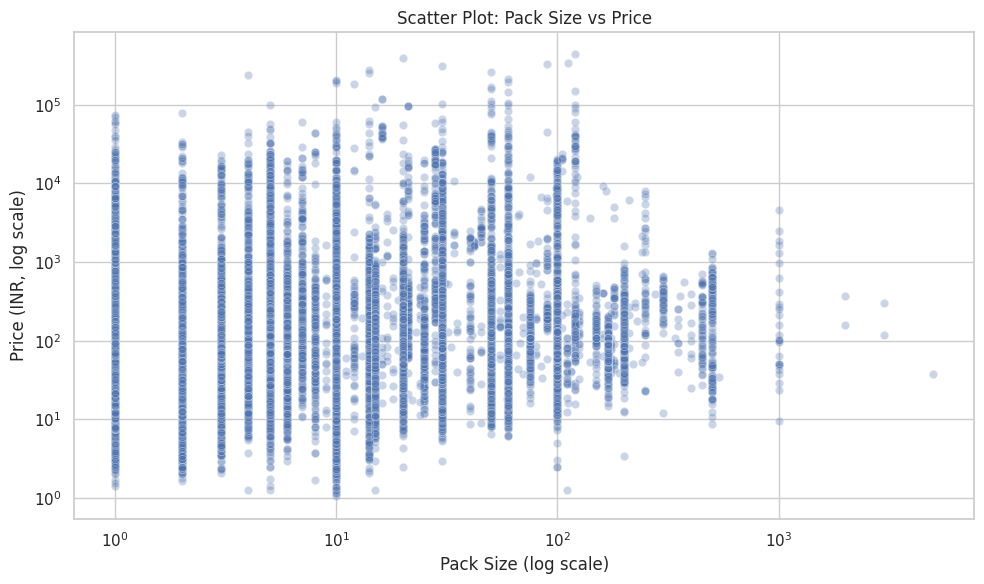

In [21]:
# Scatterplot: Harga vs Ukuran Kemasan (pack_size)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pack_size', y='price_inr', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Scatter Plot: Pack Size vs Price')
plt.xlabel('Pack Size (log scale)')
plt.ylabel('Price (INR, log scale)')
plt.tight_layout()
plt.show()

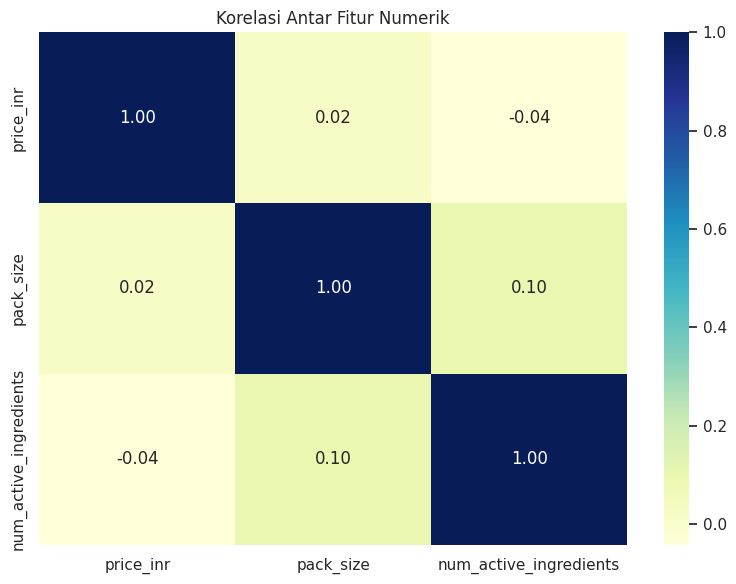

In [22]:
numerical_cols = [
    'price_inr',                 # target
    'pack_size',
    'num_active_ingredients',              
]

# Hitung korelasi
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()

# Data Preprocessing

In [23]:
df_model = df.copy()

In [24]:
df_model = df.dropna(subset=["pack_size", "pack_unit", "primary_strength"]).copy()

In [25]:
df_model.drop(columns=[
    'product_id', 'manufacturer_raw', 'packaging_raw', 'active_ingredients'
], inplace=True)

In [26]:
df_model['price_log'] = np.log1p(df_model['price_inr'])

In [27]:
# Hitung kuartil dan IQR
Q1 = df_model['price_log'].quantile(0.25)
Q3 = df_model['price_log'].quantile(0.75)
IQR = Q3 - Q1

# Batas bawah dan atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Deteksi outlier
outliers = df_model[(df_model['price_log'] < lower_bound) | (df_model['price_log'] > upper_bound)]
print(f"Jumlah outlier: {len(outliers)}")

Jumlah outlier: 5972


In [28]:
# Filter data tanpa outlier
df_no_outliers = df_model[(df_model['price_log'] >= lower_bound) & (df_model['price_log'] <= upper_bound)].copy()

# Hapus kolom bantu
df_no_outliers.drop(columns=['price_log'], inplace=True)

print(f"Jumlah data setelah outlier dibuang: {len(df_no_outliers)}")

Jumlah data setelah outlier dibuang: 202682


In [29]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202682 entries, 0 to 253970
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   brand_name              202682 non-null  object 
 1   manufacturer            202682 non-null  object 
 2   price_inr               202682 non-null  float64
 3   is_discontinued         202682 non-null  bool   
 4   dosage_form             202682 non-null  object 
 5   pack_size               202682 non-null  float64
 6   pack_unit               202682 non-null  object 
 7   num_active_ingredients  202682 non-null  int64  
 8   primary_ingredient      202682 non-null  object 
 9   primary_strength        202682 non-null  object 
 10  therapeutic_class       202682 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 17.2+ MB


In [30]:
def extract_strength(text):
    if pd.isnull(text): return np.nan
    match = re.search(r'(\d+\.?\d*)', str(text))
    return float(match.group(1)) if match else np.nan
    
df_no_outliers['primary_strength_mg'] = df_no_outliers['primary_strength'].apply(extract_strength)
df_no_outliers.drop(columns='primary_strength', inplace=True)

In [34]:
# Target prediksi: price_inr
target = 'price_inr'

categorical_features = [
    'manufacturer',
    'dosage_form',
    'pack_unit',
    'primary_ingredient',
    'therapeutic_class'
]

numeric_features = [
    'pack_size',
    'num_active_ingredients',
    'primary_strength_mg',
    'is_discontinued'
]

features = categorical_features + numeric_features
X = df_no_outliers[features]
y = df_no_outliers[target]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [36]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Modelling

In [37]:
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    ))
])

In [38]:
xgb_pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer',
                                                   'dosage_form', 'pack_unit',
                                                   'primary_ingredient',
                                                   'therapeutic_class']),
                                                 ('num', StandardScaler(),
                                                  ['pack_size',
                                                   'num_active_ingredients',
                                                   'primary_strength_mg',
                                                   'is_discontinued'])])),
                ('regressor',
                 XGBRegressor(b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [39]:
y_pred_log = xgb_pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, y.max())  

# Evaluation

In [40]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²    : {r2:.3f}")

MAE  : 38.05
RMSE : 66.34
R²    : 0.417


In [41]:
joblib.dump(xgb_pipeline, 'xgb_price_predictor.joblib')

['xgb_price_predictor.joblib']

In [42]:
df_no_outliers.to_csv("pharma_data_cleaned.csv", index=False)